# 1. Define goal
Create a model that predicts bike sharing demand.

## Current status:

**Best submission on Kaggle so far: 0.41928** with RandomForestRegressor (log transform to reduce outlier influence, target = casual + registered, Hyperparameter Optimatization for RandomForestRegressor)



### Ideas to improve:
1.  not using year but making the months of the two years (24 months)  a continous variable with Radial Base Function (RBF)

3. use scoring function for rmslr in GridSearch --> 3.9.3. Custom Scoring Function
4. Use feature selection to remove unnecessary features



### Working on:


### Done:
2.  train casual and registered seperatly and combine the number to get the count value (casual and registered user have a very different behaviour)
5. Deal with outliers (log transformation?)


# 2. Get data

In [548]:
# import packages
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # set seaborn as default style
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split

# feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer,StandardScaler, MinMaxScaler,OneHotEncoder,PolynomialFeatures
from sklearn.pipeline import Pipeline



# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet



# for testing
from sklearn.metrics import mean_squared_log_error


# miscellaneous
import time
import warnings
warnings.filterwarnings("ignore")

In [549]:
df = pd.read_csv('data/train.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Data Fields**

**datetime** - hourly date + timestamp\
**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter\
**holiday** - whether the day is considered a holiday\
**workingday** - whether the day is neither a weekend nor holiday\
"Working Day" (workingday=1, holiday=0),\
"Holiday" (workingday=0, holiday=1), and\
"Weekend" (workingday=0, holiday=0).\
Presumably there is no case where workingday=1 and holiday=1?


**weather** - 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy \
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

**temp** - temperature in Celsius\
**atemp** - "feels like" temperature in Celsius\
**humidity** - relative humidity\
**windspeed** - wind speed\
**casual** - number of non-registered user rentals initiated\
**registered** - number of registered user rentals initiated\
**count** - number of total rentals

In [481]:
df.shape

(10886, 12)

In [550]:
# extract year, month and hour from datetime into new columns
# inspired by: https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column
df['year'] = pd.DatetimeIndex(df['datetime']).year
df['month'] = pd.DatetimeIndex(df['datetime']).month
df['Month'] = pd.to_datetime(df['datetime']).dt.to_period('M')
df['hour'] = pd.DatetimeIndex(df['datetime']).hour
df.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,Month,hour
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,2012-12,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,2012-12,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,2012-12,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,2012-12,22
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,2012,12,2012-12,23


In [551]:
# set datetime as index
df.set_index(pd.to_datetime(df['datetime']), inplace= True)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,Month,hour
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,2011-01,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,2011-01,1
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2011-01,2
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,2011-01,3
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,2011-01,4


In [552]:
# remove unnecessary column
df.drop(['datetime'], axis = 1, inplace= True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,Month,hour
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,2011-01,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,2011-01,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2011-01,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,2011-01,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,2011-01,4


In [553]:
df['hour_bins']=pd.cut(df['hour'], bins=[-1,6,9,15,19,23], labels =['night','morgning-rush','midday-low','afterwork-rush','evening-low'])
df.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,Month,hour,hour_bins
datetime,,,,,,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,2012-12,19,afterwork-rush
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,2012-12,20,evening-low
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,2012-12,21,evening-low
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,2012-12,22,evening-low
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,2012,12,2012-12,23,evening-low


In [486]:
df['hour_bins'].unique()

['night', 'morgning-rush', 'midday-low', 'afterwork-rush', 'evening-low']
Categories (5, object): ['night' < 'morgning-rush' < 'midday-low' < 'afterwork-rush' < 'evening-low']

# 3. Train-test-split

In [517]:
# # Define Variable of interest
# X = df[['workingday', 'atemp', 'month','year', 'hour', 'humidity', 'weather', 'season']]
# y = df['count']
# y_casual = df['casual']
# y_registered = df['registered']
# X.head()

,workingday,atemp,month,year,hour,humidity,weather,season
datetime,,,,,,,,
2011-01-01 00:00:00,0,14.395,1,2011,0,81,1,1
2011-01-01 01:00:00,0,13.635,1,2011,1,80,1,1
2011-01-01 02:00:00,0,13.635,1,2011,2,80,1,1
2011-01-01 03:00:00,0,14.395,1,2011,3,75,1,1
2011-01-01 04:00:00,0,14.395,1,2011,4,75,1,1


In [554]:
# Define Variable of interest with log transformation
X = df[['workingday', 'atemp', 'month','year', 'hour', 'humidity', 'weather', 'season']]
y = np.log(df['count']+1)
y_casual = np.log(df['casual']+1)
y_registered = np.log(df['registered']+1)
X.head()

,workingday,atemp,month,year,hour,humidity,weather,season
datetime,,,,,,,,
2011-01-01 00:00:00,0,14.395,1,2011,0,81,1,1
2011-01-01 01:00:00,0,13.635,1,2011,1,80,1,1
2011-01-01 02:00:00,0,13.635,1,2011,2,80,1,1
2011-01-01 03:00:00,0,14.395,1,2011,3,75,1,1
2011-01-01 04:00:00,0,14.395,1,2011,4,75,1,1


In [555]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((8708, 8), (2178, 8))

In [556]:
X_train_c,X_test_c,y_train_c,y_test_c = train_test_split(X,y_casual,test_size=0.2,random_state=42)
X_train_c.shape, X_test_c.shape

((8708, 8), (2178, 8))

In [557]:
X_train_r,X_test_r,y_train_r,y_test_r = train_test_split(X,y_registered,test_size=0.2,random_state=42)
X_train_r.shape, X_test_r.shape

((8708, 8), (2178, 8))

### Checking for correlated varibales

<AxesSubplot: >

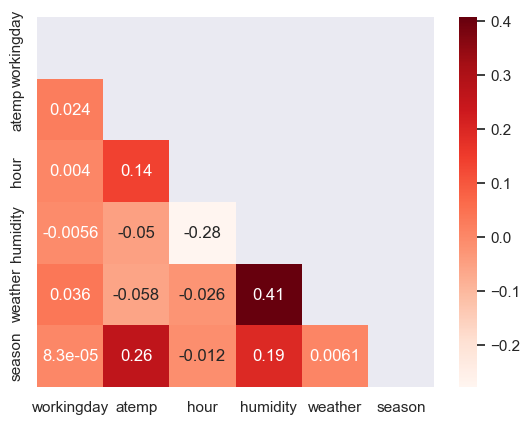

In [375]:
mask = np.triu(np.ones_like(X_train.corr(), dtype=bool))
sns.heatmap(X_train.corr(), annot = True, mask=mask, cmap='Reds')

# 4. Explore data

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
 11  year        10886 non-null  int64  
 12  month       10886 non-null  int64  
 13  hour        10886 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 1.5 MB


In [11]:
df['workingday'].unique()

array([0, 1])

In [12]:
df['holiday'].unique()

array([0, 1])

In [197]:
# there are no workingdays which are also holidays
len(df[(df['workingday'] == 1) & (df['holiday'] == 1)])

0

In [198]:
# number of workingdays (Mo-Fr)
len(df[(df['workingday'] == 1) & (df['holiday'] == 0)])

7412

In [199]:
# number of holidays
len(df[(df['workingday'] == 0) & (df['holiday'] == 1)])

311

In [200]:
# number of weekenddays which are not a holiday
len(df[(df['workingday'] == 0) & (df['holiday'] == 0)])

3163

In [13]:
df['season'].unique()

array([1, 2, 3, 4])

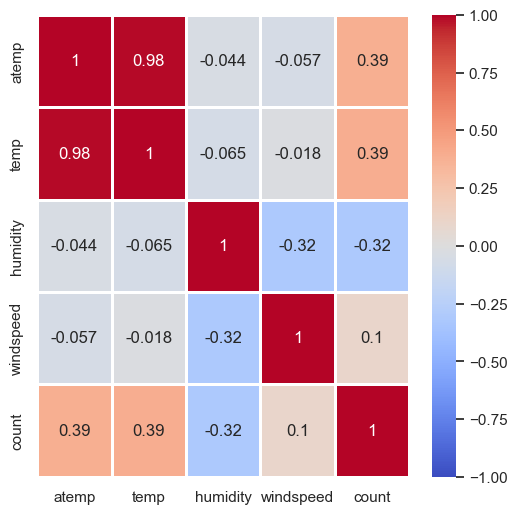

In [292]:
# checking correlation
plt.figure(figsize=(6,6),dpi=100)
sns.heatmap(
    data=df[['atemp','temp','humidity','windspeed','count']].corr(),
    cmap='coolwarm',
    linecolor='white',
    linewidth=1,
    annot=True,
    vmin=-1,
    vmax=1
);

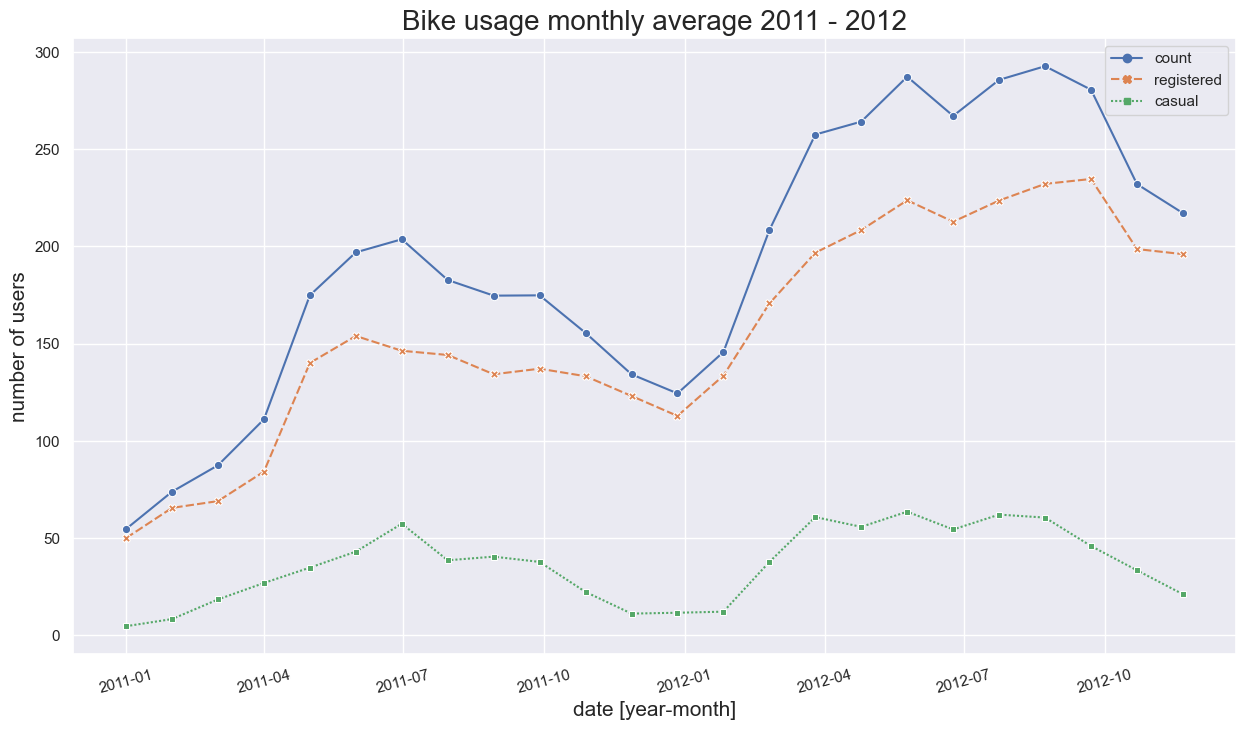

In [305]:
# bike usage monthly average for the whole dataset
plt.figure(figsize=(15,8))
sns.lineplot(data=df[['count','registered', 'casual']].resample('30D').mean(), markers=True)

plt.xticks(rotation=15)
plt.ylabel('number of users', size = 15)
plt.xlabel('date [year-month]', size= 15)

plt.title('Bike usage monthly average 2011 - 2012', size=20)

plt.show()

In [153]:
df.groupby(['weather', 'workingday'])['count'].agg(['mean'])

mean
weather workingday            
1       0           203.345941
        1           206.156231
2       0           166.529543
        1           184.709861
3       0           120.633929
        1           118.215748
4       1           164.000000

### Influence of casual and registered users

In [172]:
df.groupby(['weather', 'workingday'])['registered', 'casual'].agg(['mean']).unstack(1)

/var/folders/zs/dkf6mjq97k926d6m48gdwfs00000gn/T/ipykernel_39093/3653141842.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['weather', 'workingday'])['registered', 'casual'].agg(['mean']).unstack(1)


registered                 casual           
                  mean                   mean           
workingday           0           1          0          1
weather                                                 
1           137.805780  178.116553  65.540161  28.039678
2           117.221851  162.501807  49.307692  22.208054
3            86.741071  106.576378  33.892857  11.639370
4                  NaN  158.000000        NaN   6.000000

/var/folders/zs/dkf6mjq97k926d6m48gdwfs00000gn/T/ipykernel_39093/1251799811.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['weather', 'workingday'])['registered', 'casual'].agg(['mean']).unstack(1).plot.bar(color = ['#d14233','#0048ba','#fa747d','#26ade4'])


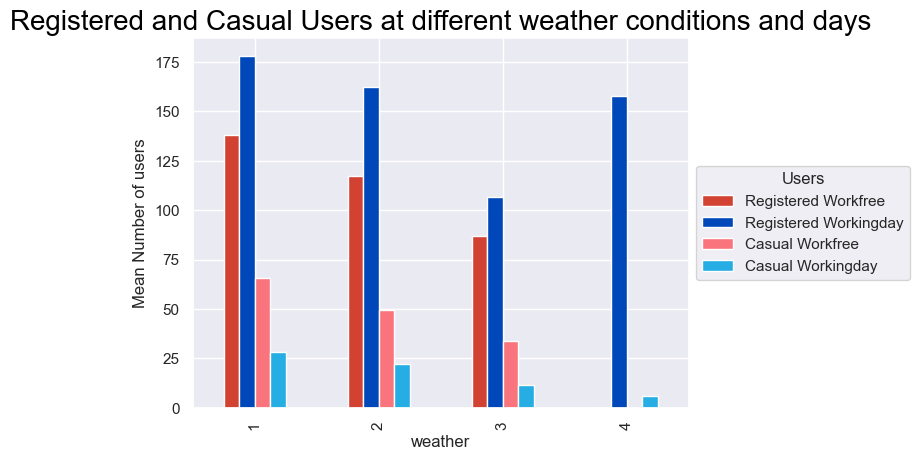

In [397]:
df.groupby(['weather', 'workingday'])['registered', 'casual'].agg(['mean']).unstack(1).plot.bar(color = ['#d14233','#0048ba','#fa747d','#26ade4'])
plt.title('Registered and Casual Users at different weather conditions and days', color='black', size = 20)
plt.ylabel('Mean Number of users')
plt.legend(title='Users',labels= ['Registered Workfree','Registered Workingday','Casual Workfree', 'Casual Workingday'], loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Registered and Casual Users at different weather conditions and days
- work free means either weekend or holiday
- in general more registered users compared to casual users
- registered users use the bike mostly at workingdays (blue) and less on workfree days (red)
- casual users use the bike more on workfree days (red) and less on workingdays (blue)
- general decrese in usage for all users with bad weather conditions (weather 4 just happended once)

In [224]:
df_melted = df.melt(id_vars = ['weather', 'workingday'],# column names from original dataframe
                   value_vars=['casual', 'registered'], # from the original dataframe
                   var_name= 'users', # new column name for the variable column
                   value_name = 'num_users')

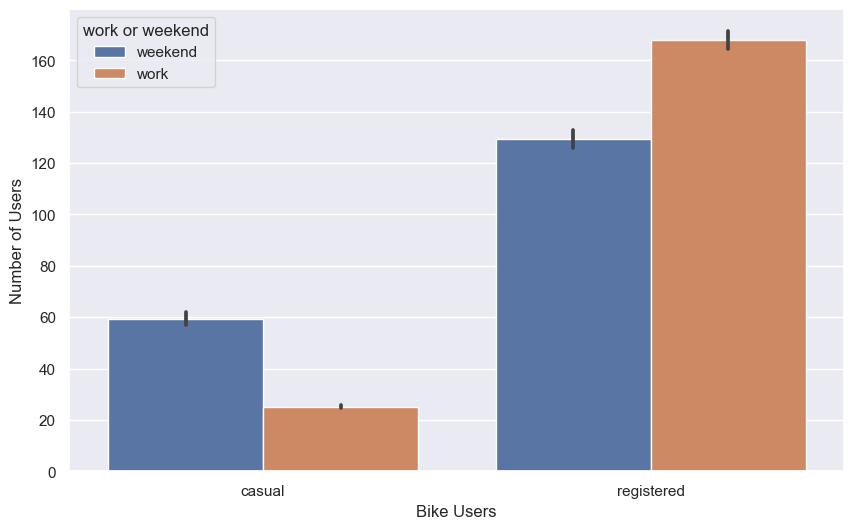

In [238]:
plt.figure(figsize = (10,6))
ax = sns.barplot(data=df_melted, y='num_users', x='users', hue = 'workingday')
plt.ylabel('Number of Users')
plt.xlabel('Bike Users')
#plt.legend(loc=(1.05, 1));
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['weekend', 'work'], title='work or weekend')
plt.show()
#sns.despine()

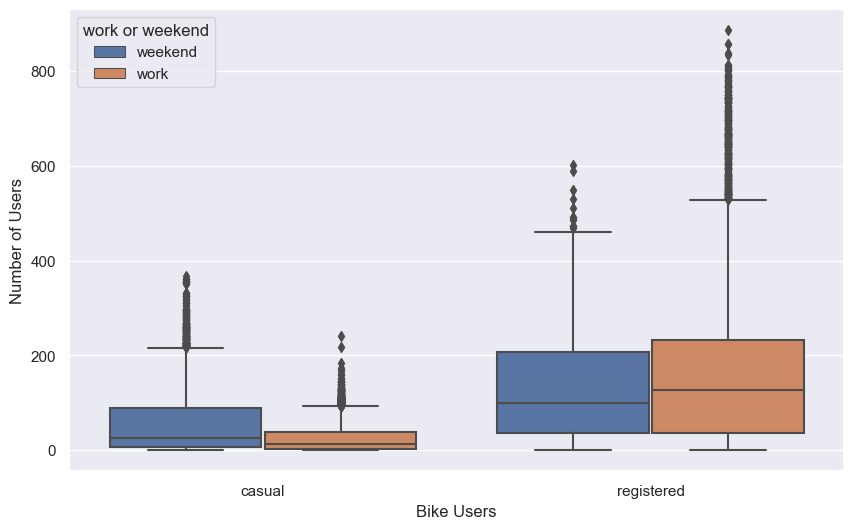

In [240]:
plt.figure(figsize = (10,6))
ax = sns.boxplot(data=df_melted, y='num_users', x='users', hue = 'workingday')
plt.ylabel('Number of Users')
plt.xlabel('Bike Users')
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['weekend', 'work'], title='work or weekend')
#sns.despine()

### Influence of weather 
Problem: Weather 4 occured only 1 time in 2012 and never in 2011 for the train.csv

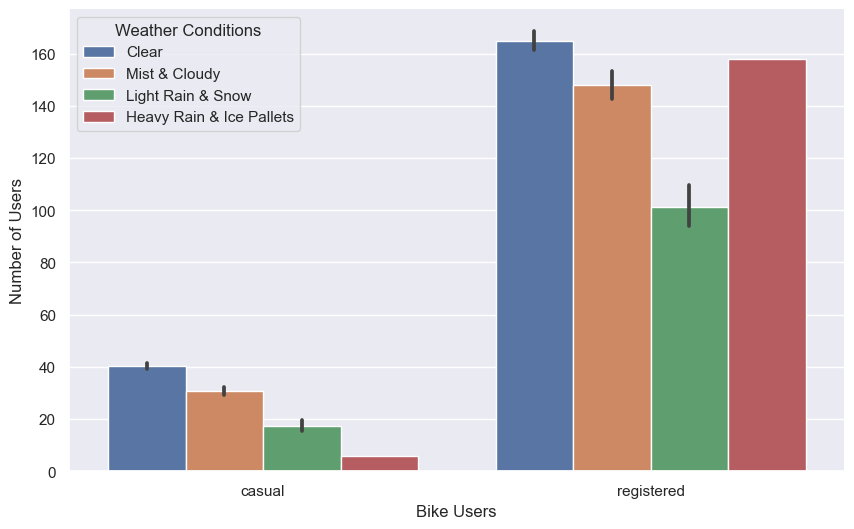

In [247]:
plt.figure(figsize = (10,6))
ax = sns.barplot(data=df_melted, y='num_users', x='users', hue = 'weather')
plt.ylabel('Number of Users')
plt.xlabel('Bike Users')
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['Clear', 'Mist & Cloudy', 'Light Rain & Snow', 'Heavy Rain & Ice Pallets'], title='Weather Conditions')
sns.despine()

<AxesSubplot: xlabel='weather'>

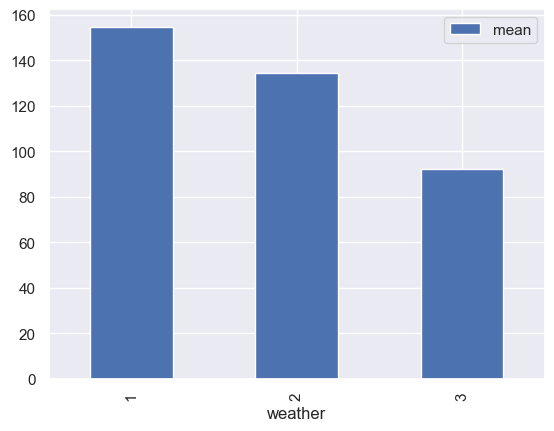

In [388]:
df_2011.groupby(['weather'])['count'].agg(['mean']).plot.bar()

In [392]:
df_2011['weather'].value_counts() #no weather4 in year 2011

1    3583
2    1366
3     473
Name: weather, dtype: int64

In [393]:
df_2012['weather'].value_counts() # only one weather4 in year 2012

1    3609
2    1468
3     386
4       1
Name: weather, dtype: int64

In [395]:
df_2012[(df['weather']==4)] # weather4 in 2012 was a working day. 
                            # So there was never a weather4 at a holiday in the test.csv but could be in the train.csv

/var/folders/zs/dkf6mjq97k926d6m48gdwfs00000gn/T/ipykernel_39093/4191102348.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2012[(df['weather']==4)]


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour
datetime,,,,,,,,,,,,,,
2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,2012,1,18


<AxesSubplot: xlabel='weather'>

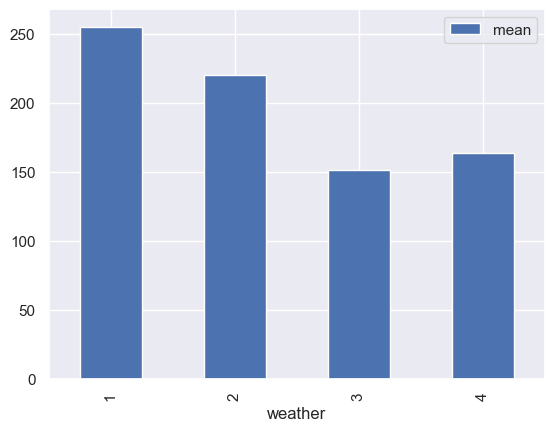

In [242]:
df_2012.groupby(['weather'])['count'].agg(['mean']).plot.bar()

###  Influence of year
Usage increase from year 2011 to year 2012

In [16]:
df.groupby(['year'])['count'].agg(['mean'])

,mean
year,
2011,144.223349
2012,238.560944


<AxesSubplot: xlabel='year'>

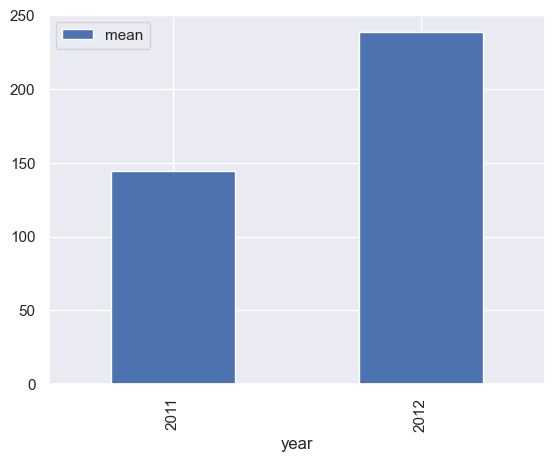

In [25]:
# comparing the two years
df.groupby(['year'])['count'].agg(['mean']).plot.bar()

In [200]:
#creating dataset for 2011
df_2011 = df[df['year']==2011]
df_2011.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,hour_bins
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,night
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,night
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,night
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,night
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,night


In [201]:
# creating dataset for 2012
df_2012 = df[df['year']==2012]
df_2012.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,hour_bins
datetime,,,,,,,,,,,,,,,
2012-01-01 00:00:00,1,0,0,1,14.76,18.940,66,0.0000,5,43,48,2012,1,0,night
2012-01-01 01:00:00,1,0,0,1,14.76,17.425,66,8.9981,15,78,93,2012,1,1,night
2012-01-01 02:00:00,1,0,0,1,13.12,17.425,76,0.0000,16,59,75,2012,1,2,night
2012-01-01 03:00:00,1,0,0,1,12.30,16.665,81,0.0000,11,41,52,2012,1,3,night
2012-01-01 04:00:00,1,0,0,1,11.48,15.150,81,6.0032,0,8,8,2012,1,4,night


###  Influence of months

<AxesSubplot: xlabel='month'>

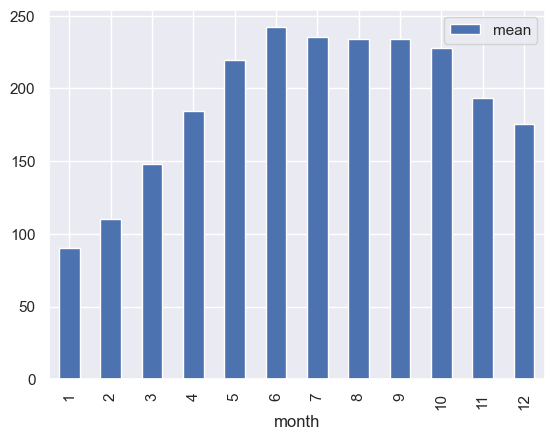

In [15]:
df.groupby(['month'])['count'].agg(['mean']).plot.bar()

<AxesSubplot: xlabel='month'>

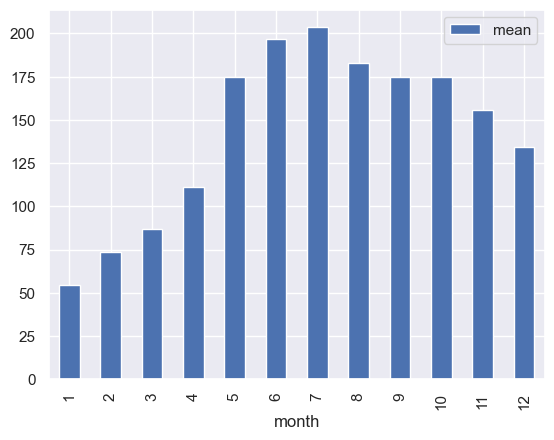

In [22]:
# comparing the months of year 2011
df_2011.groupby(['month'])['count'].agg(['mean']).plot.bar()

<AxesSubplot: xlabel='month'>

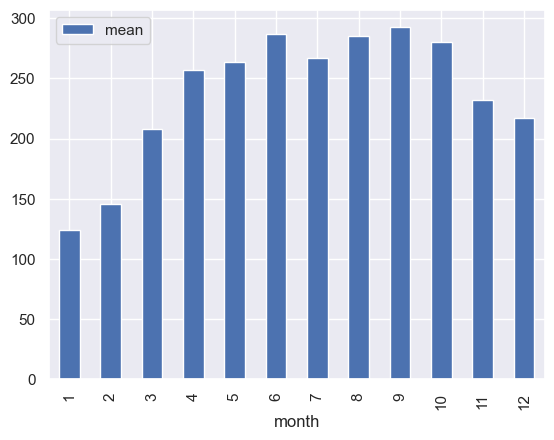

In [24]:
# comparing the months of year 2012
df_2012.groupby(['month'])['count'].agg(['mean']).plot.bar()

### Creating dataset for workday and weekend(--> weekend should be changed to workfree)

In [33]:
# probably better to call it workfree because it is all weekend days and holidays
weekend = df[df['workingday'] == 0]
weekend.shape

(3474, 14)

In [250]:
# only weekend days without holidays
weekend_ohne_hol = df[(df['workingday'] == 0) & (df['holiday'] == 0)]
weekend_ohne_hol.shape

(3163, 14)

In [34]:
workday = df[df['workingday'] == 1]
workday.shape

(7412, 14)

In [248]:
# only holidays
holiday = df[(df['workingday'] == 0) & (df['holiday'] == 1)]
holiday.shape

(311, 14)

### Influence of hour
- for working and workfree days
- for casual and registered users

<AxesSubplot: xlabel='hour'>

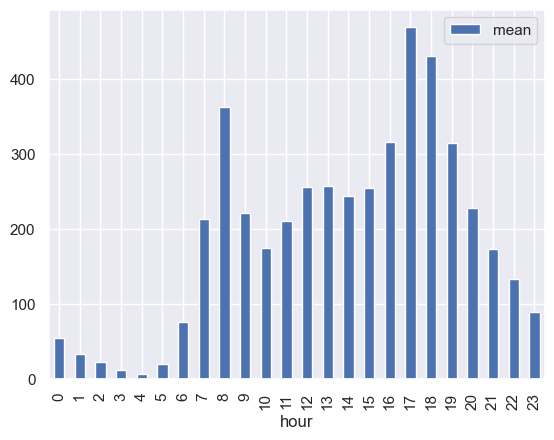

In [26]:
df.groupby(['hour'])['count'].agg(['mean']).plot.bar()

<AxesSubplot: xlabel='hour', ylabel='count'>

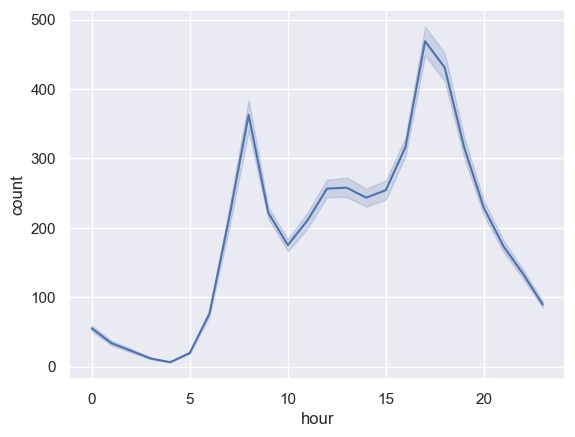

In [181]:
sns.lineplot(data=df, x='hour', y='count')


<AxesSubplot: xlabel='hour', ylabel='count'>

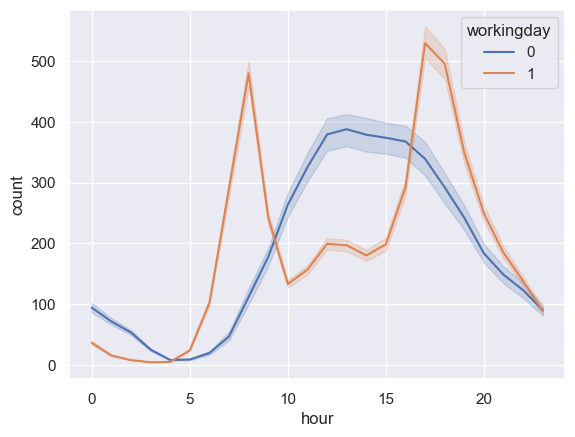

In [592]:
sns.lineplot(data=df, x='hour', y='count', hue='workingday')


<AxesSubplot: xlabel='hour', ylabel='registered'>

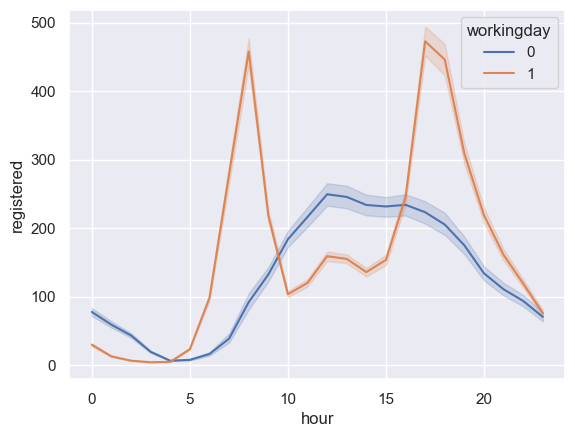

In [220]:
sns.lineplot(data=df, x='hour', y='registered', hue='workingday')


<AxesSubplot: xlabel='hour', ylabel='casual'>

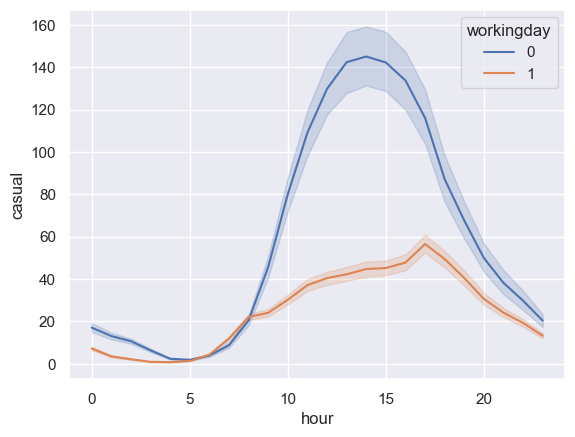

In [219]:
sns.lineplot(data=df, x='hour', y='casual', hue='workingday')


###  Some more testing visualization

<AxesSubplot: xlabel='atemp'>

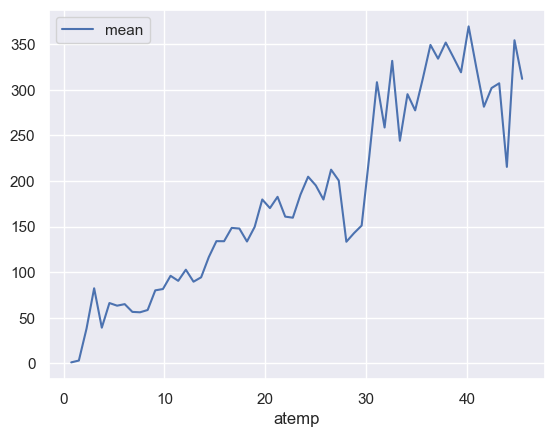

In [45]:
df.groupby(['atemp'])['count'].agg(['mean']).plot.line()

<AxesSubplot: xlabel='humidity'>

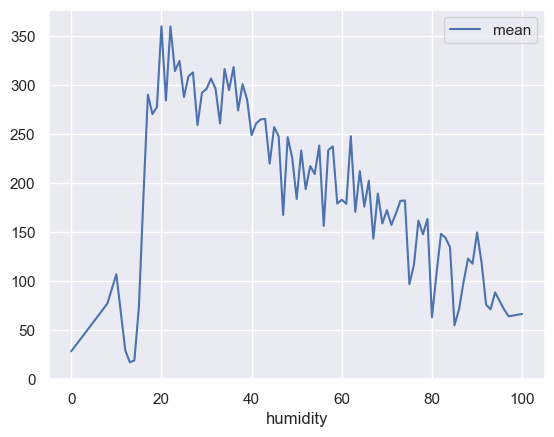

In [450]:
df.groupby(['humidity'])['count'].agg(['mean']).plot.line()

<AxesSubplot: xlabel='windspeed'>

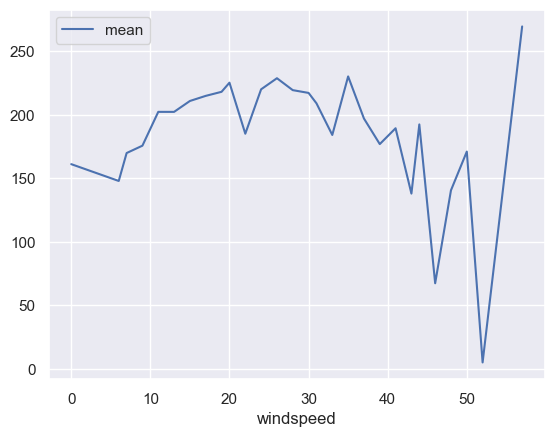

In [451]:
df.groupby(['windspeed'])['count'].agg(['mean']).plot.line()

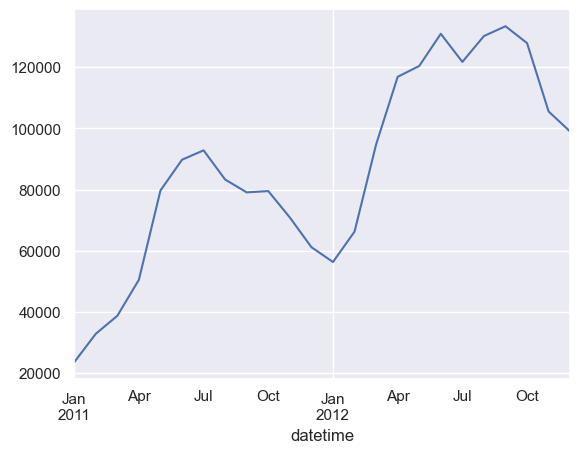

In [576]:
df['count'].resample('M').sum().plot();

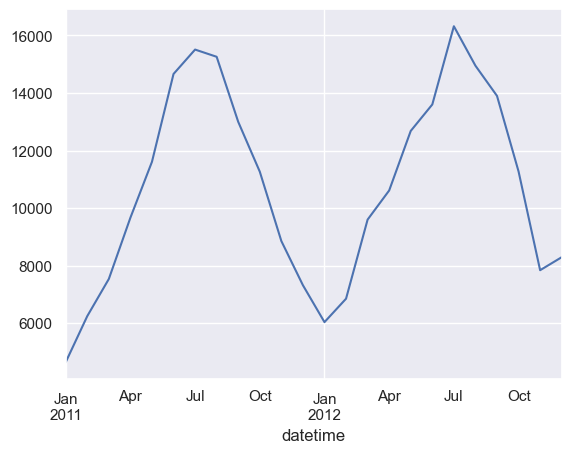

In [578]:
df['atemp'].resample('M').sum().plot();

### Plotting ideas:
- influence of Temperature on bike rental
- change weekend to workfree (only holiday not so important)
- influence of humidity on bike rental

# 5. Feature Engineer

- workingday - will leave like it is
- atemp - scaling with MinMaxScaler\ (temp and atemp are very similar, I only use atemp)
- humidity - scaling with MinMaxScaler\
- year - cat feature - onehot\ --> to do: make continues var for 24 months
- month - cat feature - onehot\
- season - cat feature - onehot\
- weather - cat feature - onehot\
- hour - binning ---> **I tried custom edge binning with pdcut, but this did not improve the model**
    - Binning of day time; 0-6, 7-9, 10-15, 16-19, 20-23 (custom bins I tried with pdcut)
    - binning into 24 bins produced the best results, but that is just like onehot?!

In [558]:
X.head()

,workingday,atemp,month,year,hour,humidity,weather,season
datetime,,,,,,,,
2011-01-01 00:00:00,0,14.395,1,2011,0,81,1,1
2011-01-01 01:00:00,0,13.635,1,2011,1,80,1,1
2011-01-01 02:00:00,0,13.635,1,2011,2,80,1,1
2011-01-01 03:00:00,0,14.395,1,2011,3,75,1,1
2011-01-01 04:00:00,0,14.395,1,2011,4,75,1,1


In [559]:
# differentiate between numerical and categorical features and columns which I want to bin
numerical_features = ['atemp', 'humidity']
categorical_features = ['month','year', 'weather', 'season']

binning_features = ['hour']

In [536]:
# column transformation
transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numerical_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features), #habe drop='first' weggenommen
    ('binning', KBinsDiscretizer(n_bins=24, encode='onehot', strategy='uniform'), binning_features)],
    remainder = 'passthrough'
)

<!-- # column transformation with out binning (hours binned with pd.cut)
transformer = ColumnTransformer([
    ('scaling', MinMaxScaler(), numerical_features),
    ('onehot', OneHotEncoder(drop='first'), categorical_features)],
    remainder = 'passthrough'
) -->

In [236]:
# fitting column transformer without pipline
transformer.fit(X_train)
X_train_fe = transformer.transform(X_train)
X_test_fe = transformer.transform(X_test) # DO NOT FIT ON TEST SET

# 6. Train model

a) **Linear Regression**
- with Feature Expansion and Regularization Test

b) **RandomForestRegressor**
- with Test of splitting data into casual and registered
- with CrossValidation and Hyperparameter Opti

c) **PoissonRegressor** 

d) **ElasticNet**
- with CrossValidation and Hyperparameter Optimazation

## 6. a) Linear Regression

#### Model Evaluation without pipline

In [121]:
# create model
LinReg = LinearRegression()

In [27]:
# train model
LinReg.fit(X_train_fe,y_train)

LinearRegression()

In [28]:
LinReg.score(X_train_fe,y_train)

0.6984627622903461

In [29]:
LinReg.score(X_test_fe, y_test)

0.6683600881656196

In [141]:
# checking RMSLE

y_train_log = np.log1p(y_train)
LinReg.fit(X_train_fe,y_train_log)
ypredLinReglog = LinReg.predict(X_train_fe)
ypredLinReg = np.exp(ypredLinReglog)-1

np.sqrt(mean_squared_log_error(y_train, ypredLinReg))

0.578816414149461

#### Model Evaluation with pipline

In [283]:
# pipeline with column transformer and LinearReg Model
pipeline = Pipeline(
    [('col_transformer', transformer),                  # step-1 column transformation
     ('lr_model', LinearRegression(fit_intercept=True)) # step-2 linear fit
    ])

In [284]:
# model training if I use pipline as in linear_regression notebook from 20th Dec. 
pipeline.fit(X_train,y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', MinMaxScaler(),
                                                  ['atemp', 'humidity']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'weather',
                                                   'season']),
                                                 ('binning',
                                                  KBinsDiscretizer(n_bins=24,
                                                                   strategy='uniform'),
                                                  ['hour'])])),
                ('lr_model', LinearRegression())])

In [285]:
# training score if I use pipline as in the linear_regression notebook from the 20th of Dec otherwise LingReg.score as above

training_score = pipeline.score(X_train,y_train)
print(f'training score: {round(training_score,6)}')

training score: 0.692294


In [286]:
# test score
test_score = pipeline.score(X_test,y_test)
print(f'test score: {round(test_score,6)}')

test score: 0.694763


### use casual and registered user seperately 

In [313]:
pipeline.fit(X_train_c,y_train_c)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', MinMaxScaler(),
                                                  ['atemp', 'humidity']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'weather',
                                                   'season']),
                                                 ('binning',
                                                  KBinsDiscretizer(n_bins=24,
                                                                   strategy='uniform'),
                                                  ['hour'])])),
                ('lr_model', LinearRegression())])

In [314]:
training_score = pipeline.score(X_train_c,y_train_c)
print(f'training score: {round(training_score,6)}')

training score: 0.590658


#### Feature Expansion / Regularization for LinearRegression

In [127]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

In [111]:
poly = PolynomialFeatures(degree = 5, include_bias = False)
X_poly = poly.fit_transform(X)

In [112]:
X_train_poly,X_test_poly,y_train,y_test = train_test_split(X_poly,y,test_size=0.2,random_state=101)
X_train_poly.shape, X_test_poly.shape

((8708, 1286), (2178, 1286))

In [113]:
y_train.shape, y_test.shape

((8708,), (2178,))

In [124]:
LinReg.fit(X_train_poly,y_train) #train the model

LinearRegression()

In [125]:
LinReg.score(X_train_poly,y_train)

0.7305491287833843

In [126]:
LinReg.score(X_train_poly,y_train)

0.7305491287833843

In [128]:
lasso = Lasso()
ridge = Ridge()
elast = ElasticNet()

In [130]:
lasso.fit(X_poly, y)
ridge.fit(X_poly, y)
elast.fit(X_poly, y)

/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.291e+07, tolerance: 3.572e+04
  model = cd_fast.enet_coordinate_descent(
/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.287e+07, tolerance: 3.572e+04
  model = cd_fast.enet_coordinate_descent(


ElasticNet()

In [132]:
lasso.score(X_train_poly,y_train), ridge.score(X_train_poly,y_train), elast.score(X_train_poly,y_train)

(0.6483140114127169, 0.7344517346572079, 0.6483388164780057)

In [133]:
lasso.score(X_test_poly,y_test), ridge.score(X_test_poly,y_test), elast.score(X_test_poly,y_test)

(0.6479214419159538, 0.7291510692088047, 0.6479014701734354)

## 6b) RandomForestRegessor with casual, registered and count as seperated targets

In [644]:
transformer_rf = ColumnTransformer([
    ('binning', KBinsDiscretizer(n_bins=24, encode='onehot', strategy='uniform'), binning_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)], #habe drop='first' weggenommen
    remainder = 'passthrough'
)

In [615]:
# # pipeline with column transformer and RandomForestRegressor
# pipeline_rf = Pipeline(
#     [('col_transformer', transformer_rf),                  
#      ('rf', RandomForestRegressor(n_estimators = 100, random_state = 0)) # change hyppara to values from optimazation
#     ])

In [646]:
# pipline with best hyperparameters 
# rf__max_depth': 50, 'rf__min_samples_split': 5, 'rf__n_estimators': 250)
pipeline_rf = Pipeline(
    [('col_transformer', transformer_rf),                  
     ('rf', RandomForestRegressor(max_depth = 50, min_samples_split = 5, n_estimators = 250)) # change hyppara to values from optimazation
    ])

### For casual as target

In [647]:
pipeline_rf.fit(X_train_c,y_train_c)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binning',
                                                  KBinsDiscretizer(n_bins=24,
                                                                   strategy='uniform'),
                                                  ['hour']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['month', 'year', 'weather',
                                                   'season'])])),
                ('rf',
                 RandomForestRegressor(max_depth=50, min_samples_split=5,
                                       n_estimators=250))])

In [648]:
training_score = pipeline_rf.score(X_train_c,y_train_c)
print(f'training score: {round(training_score,6)}')

training score: 0.964611


In [649]:
# test score
test_score = pipeline_rf.score(X_test_c,y_test_c)
print(f'test score: {round(test_score,6)}')

test score: 0.857885


In [568]:
# predictions_casual = pipeline_rf.predict(test)
# output = pd.DataFrame({'datetime': df_test.index, 'casual': predictions_casual})
# output.to_csv('submission_rf_casual.csv', index=False)

In [650]:
#prediction retransformation of log
predictions_casual_log = pipeline_rf.predict(test)
predictions_casual = np.exp(predictions_casual_log) - 1
output = pd.DataFrame({'datetime': df_test.index, 'casual': predictions_casual})
output.to_csv('submission_rf_casual.csv', index=False)

### For registered as target

In [651]:
pipeline_rf.fit(X_train_r,y_train_r)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binning',
                                                  KBinsDiscretizer(n_bins=24,
                                                                   strategy='uniform'),
                                                  ['hour']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['month', 'year', 'weather',
                                                   'season'])])),
                ('rf',
                 RandomForestRegressor(max_depth=50, min_samples_split=5,
                                       n_estimators=250))])

In [652]:
training_score = pipeline_rf.score(X_train_r,y_train_r)
print(f'training score: {round(training_score,6)}')

training score: 0.982643


In [653]:
# test score
test_score = pipeline_rf.score(X_test_r,y_test_r)
print(f'test score: {round(test_score,6)}')

test score: 0.939563


In [572]:
# predictions_reg = pipeline_rf.predict(test)
# output = pd.DataFrame({'datetime': df_test.index, 'registered': predictions_reg})
# output.to_csv('submission_rf_reg.csv', index=False)

In [654]:
#prediction retransformation of log
predictions_reg_log = pipeline_rf.predict(test)
predictions_reg = np.exp(predictions_reg_log) - 1
output = pd.DataFrame({'datetime': df_test.index, 'registered': predictions_reg})
output.to_csv('submission_rf_reg.csv', index=False)

### For count as target

In [655]:
pipeline_rf.fit(X_train,y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binning',
                                                  KBinsDiscretizer(n_bins=24,
                                                                   strategy='uniform'),
                                                  ['hour']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['month', 'year', 'weather',
                                                   'season'])])),
                ('rf',
                 RandomForestRegressor(max_depth=50, min_samples_split=5,
                                       n_estimators=250))])

In [656]:
# training score
training_score = pipeline_rf.score(X_train,y_train)
print(f'training score: {round(training_score,6)}')

training score: 0.982993


In [657]:
# test score
test_score = pipeline_rf.score(X_test,y_test)
print(f'test score: {round(test_score,6)}')

test score: 0.937819


In [576]:
# predictions_count = pipeline_rf.predict(test)
# output = pd.DataFrame({'datetime': df_test.index, 'count': predictions_count})
# output.to_csv('submission_rf_count.csv', index=False)

In [658]:
#prediction retransformation of log
predictions_count_log = pipeline_rf.predict(test)
predictions_count = np.exp(predictions_count_log) - 1
output = pd.DataFrame({'datetime': df_test.index, 'count': predictions_count})
output.to_csv('submission_rf_count.csv', index=False)

### 6.bb) Cross-Validation and Hyperparameter Optimatization with RandomForestRegressor

In [634]:
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features), #habe drop='first' weggenommen
    ('binning', KBinsDiscretizer(n_bins=24, encode='onehot', strategy='uniform'), binning_features)],
    remainder = 'passthrough'
)

In [635]:
estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # preprocessing step
        ('rf', RandomForestRegressor()) # random forest regression
    ]
)

In [636]:
param_grid = {
    'rf__n_estimators': [50,100,250,500],
    'rf__max_depth': [5,50,100,None],
    'rf__min_samples_split': [2, 5, 10]
}

In [637]:
gscv = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='r2',
    cv=5, 
    n_jobs=-1,
    verbose=1
)

In [638]:
# initial time
ti = time.time()

# grid-search cross-validation
gscv.fit(X_train,y_train)

# final time 
tf = time.time()

# time taken
print(f"time taken: {round(tf-ti,2)} sec")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
time taken: 609.89 sec


In [639]:
gscv.best_params_

{'rf__max_depth': 50, 'rf__min_samples_split': 5, 'rf__n_estimators': 250}

In [640]:
gscv.best_score_

0.9372664712150565

In [641]:
best_model_rf = gscv.best_estimator_
best_model_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'year', 'weather',
                                                   'season']),
                                                 ('binning',
                                                  KBinsDiscretizer(n_bins=24,
                                                                   strategy='uniform'),
                                                  ['hour'])])),
                ('rf',
                 RandomForestRegressor(max_depth=50, min_samples_split=5,
                                       n_estimators=250))])

In [642]:
best_model_rf.fit(X_train,y_train);

In [643]:
# training score
training_score = best_model_rf.score(X_train,y_train)

# test score
test_score = best_model_rf.score(X_test,y_test)

print(f'Train score: {round(training_score,6)}')
print(f'Test score : {round(test_score,6)}')

Train score: 0.983767
Test score : 0.940912


## 6.c) Poisson Regression

In [134]:
from sklearn.linear_model import PoissonRegressor
pr = PoissonRegressor()

In [137]:
pr.fit(X_train_fe, y_train)

PoissonRegressor()

In [138]:
pr.score(X_train_fe, y_train)

0.7791147849615921

In [139]:
pr.score(X_test_fe, y_test)

0.7565944119198649

## 6.d) ElasticNet with Cross-Validation and Hyperparameter Optimatization

In [ ]:
numerical_features = ['atemp', 'humidity']
categorical_features = ['year', 'month', 'weather', 'season', 'hour'] #binning for hour?!

#### Feature Engineering

In [72]:
# scaling and polynomial features
numerical_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('polynomial', PolynomialFeatures())
    ]
)

In [73]:
# one-hot encoding
categorical_transformer = Pipeline(
    steps=[
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

In [74]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [75]:
estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),   # preprocessing step
        ('elast', ElasticNet()) # lasso regression
    ]
)

In [76]:
param_grid = {
    'preprocessor__num__polynomial__degree': [2,3,5],
    'preprocessor__num__polynomial__interaction_only': [False,True],
    'elast__alpha': [100.,10.,1.,0.1,0.01],
    'elast__l1_ratio':[0,0.5,1]
}

#### Grid-search & cross validation

In [77]:
from sklearn.model_selection import GridSearchCV
import time

In [78]:
gscv = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='r2',
    cv=5, 
    n_jobs=-1,
    verbose=1
)

In [79]:
# initial time
ti = time.time()

# grid-search cross-validation
gscv.fit(X_train,y_train)

# final time 
tf = time.time()

# time taken
print(f"time taken: {round(tf-ti,2)} sec")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
time taken: 19.18 sec


In [80]:
# all results
gscv.cv_results_

{'mean_fit_time': array([0.9469234 , 0.82346792, 1.15795131, 0.80720897, 0.46798344,
        0.79691601, 0.02122259, 0.01769395, 0.02195559, 0.01853275,
        0.02183404, 0.01962318, 0.01619658, 0.01551428, 0.02155499,
        0.01841016, 0.01945763, 0.01608787, 0.87651796, 0.80399923,
        1.08238521, 0.81164899, 0.46621838, 0.81942792, 0.01685152,
        0.01585889, 0.02020855, 0.01821613, 0.02170787, 0.01947351,
        0.020824  , 0.0181695 , 0.03611422, 0.02047944, 0.0346674 ,
        0.0191947 , 0.93640876, 0.8265625 , 1.13051028, 0.81623068,
        0.50803952, 0.79968433, 0.02371936, 0.02153463, 0.02933068,
        0.01966686, 0.03787017, 0.02032089, 0.03581944, 0.0247695 ,
        0.04385605, 0.02766342, 0.0536129 , 0.03013639, 0.91355777,
        0.82445436, 1.11597862, 0.79780202, 0.46587181, 0.80970964,
        0.02946701, 0.02792678, 0.03810496, 0.03186083, 0.10025349,
        0.03377218, 0.07458978, 0.06833539, 0.11211534, 0.0678587 ,
        0.16053367, 0.07348003,

In [81]:
# list of columns to show
column_list = ['param_preprocessor__num__polynomial__degree',
               'param_preprocessor__num__polynomial__interaction_only',
               'param_elast__alpha',
               'param_elast__l1_ratio',
               'mean_test_score',
               'std_test_score',
               'rank_test_score'
              ]
# create result dataframe
result_df = pd.DataFrame(gscv.cv_results_)[column_list]

# rename columns
result_df.rename(
    columns=lambda name: name.split('__')[-1],inplace=True
)

# order by rank
result_df.sort_values(
    by='rank_test_score', ascending=True, inplace=True, ignore_index=True
)

result_df

,degree,interaction_only,alpha,l1_ratio,mean_test_score,std_test_score,rank_test_score
0,5,False,0.01,1,0.712635,0.004838,1
1,5,False,0.1,1,0.710926,0.005718,2
2,3,False,0.01,1,0.709759,0.005328,3
3,3,False,0.1,1,0.708110,0.005936,4
4,2,False,0.01,1,0.702822,0.005602,5
...,...,...,...,...,...,...,...
85,5,True,100.0,0.5,0.002202,0.000094,83
86,2,True,100.0,1,-0.000100,0.000121,87
87,3,True,100.0,1,-0.000100,0.000121,87
88,5,True,100.0,1,-0.000100,0.000121,87


In [82]:
gscv.best_params_

{'elast__alpha': 0.01,
 'elast__l1_ratio': 1,
 'preprocessor__num__polynomial__degree': 5,
 'preprocessor__num__polynomial__interaction_only': False}

In [83]:
gscv.best_score_

0.7126351569157465

In [84]:
best_model = gscv.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures(degree=5))]),
                                                  ['atemp', 'humidity']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['year', 'month', 'weather',
                                                   'season', 'hour'])])),
                ('elast', ElasticNet(alpha=0.01, l1_ratio=1))])

In [85]:
best_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures(degree=5))]),
                                                  ['atemp', 'humidity']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['year', 'month', 'weather',
                                                   'season', 'hour'])])),
                ('elast', ElasticNet(alpha=0.01, l1_ratio=1))])

In [86]:
# training score
training_score = best_model.score(X_train,y_train)

# test score
test_score = best_model.score(X_test,y_test)

print(f'Train score: {round(training_score,6)}')
print(f'Test score : {round(test_score,6)}')

Train score: 0.716702
Test score : 0.685406


/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114573445.85862553, tolerance: 22990.567459948314
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112550430.79989909, tolerance: 22852.684305554783
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114223706.55097933, tolerance: 22922.301298320413
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115696871.70379838, tolerance: 23217.613745428465
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114223706.55097933, tolerance: 22922.301298320413
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/heikesigloch/opt/a

/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114574038.93002333, tolerance: 22990.567459948314
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113875604.36023928, tolerance: 22852.684305554783
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114574038.93002333, tolerance: 22990.567459948314
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/heikesigloch/opt/a

/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113875157.2521666, tolerance: 22852.684305554783
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112899287.74890095, tolerance: 22922.301298320413
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.093e+08, tolerance: 2.299e+04 Linear regression model

/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115832957.6481637, tolerance: 23244.63709883721
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115833416.87794541, tolerance: 23244.63709883721
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/heikesigloch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113875604.36023928, tolerance: 22852.684305554783
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/heikesigloch/opt/anac

## Submission for Kaggel

In [404]:
df_test = pd.read_csv('data/test.csv')
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [406]:
# extract year, month and hour
df_test['year'] = pd.DatetimeIndex(df_test['datetime']).year
df_test['month'] = pd.DatetimeIndex(df_test['datetime']).month
df_test['Month'] = pd.to_datetime(df_test['datetime']).dt.to_period('M')
df_test['hour'] = pd.DatetimeIndex(df_test['datetime']).hour
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,Month,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,2011-01,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2011-01,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2011-01,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,2011-01,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,2011-01,4


In [407]:
# set datetime as index
df_test.set_index(pd.to_datetime(df_test['datetime']), inplace= True)
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,Month,hour
datetime,,,,,,,,,,,,,
2011-01-20 00:00:00,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,2011-01,0
2011-01-20 01:00:00,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2011-01,1
2011-01-20 02:00:00,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2011-01,2
2011-01-20 03:00:00,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,2011-01,3
2011-01-20 04:00:00,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,2011-01,4


In [408]:
# remove unnecessary column
df_test.drop(['datetime'], axis = 1, inplace= True)
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,Month,hour
datetime,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,2011-01,0
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2011-01,1
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2011-01,2
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,2011-01,3
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,2011-01,4


In [409]:
# df_test['hour_bins']=pd.cut(df_test['hour'], bins=[-1,6,9,15,19,23], labels =['night','morgning-rush','midday-low','afterwork-rush','evening-low'])
# df.head()

In [567]:
test = df_test[['workingday', 'atemp', 'month','year','hour','humidity', 'weather', 'season']]
test.head()

,workingday,atemp,month,year,hour,humidity,weather,season
datetime,,,,,,,,
2011-01-20 00:00:00,1,11.365,1,2011,0,56,1,1
2011-01-20 01:00:00,1,13.635,1,2011,1,56,1,1
2011-01-20 02:00:00,1,13.635,1,2011,2,56,1,1
2011-01-20 03:00:00,1,12.880,1,2011,3,56,1,1
2011-01-20 04:00:00,1,12.880,1,2011,4,56,1,1


In [195]:
test_fe = transformer.transform(test)

In [571]:
#predictions from RandomForestRegressor
predictions = rfr.predict(test_fe)
output = pd.DataFrame({'datetime': df_test.index, 'count': predictions})
output.to_csv('submission_rfr_6.csv', index=False)

In [386]:
#predictions from PoissionRegressor
predictions_pr = pr.predict(test_fe)
output = pd.DataFrame({'datetime': df_test.index, 'count': predictions_pr})
output.to_csv('submission_pr_1.csv', index=False)

In [198]:
#predictions from best RandomForestRegressor
predictions_best_rf = best_model_rf.predict(test)
output = pd.DataFrame({'datetime': df_test.index, 'count': predictions_best_rf})
output.to_csv('submission_best_rf.csv', index=False)

In [ ]:
pd.DataFrame({'importance': rf.feature_importances_, 'feature':X_train.columns}).\
sort_values('importance', ascending=False)

### Kaggel Submission for  target = casual + registered

In [659]:
casual = pd.read_csv('submission_rf_casual.csv')
casual.head()

,datetime,casual
0,2011-01-20 00:00:00,1.463793
1,2011-01-20 01:00:00,1.028761
2,2011-01-20 02:00:00,1.445257
3,2011-01-20 03:00:00,0.774575
4,2011-01-20 04:00:00,0.035105


In [660]:
reg = pd.read_csv('submission_rf_reg.csv')
reg.head()

,datetime,registered
0,2011-01-20 00:00:00,9.895920
1,2011-01-20 01:00:00,3.820677
2,2011-01-20 02:00:00,2.938509
3,2011-01-20 03:00:00,1.764336
4,2011-01-20 04:00:00,1.540172


In [661]:
df_count = pd.read_csv('submission_rf_count.csv')
df_count.head()

,datetime,count
0,2011-01-20 00:00:00,10.413635
1,2011-01-20 01:00:00,4.264928
2,2011-01-20 02:00:00,3.747139
3,2011-01-20 03:00:00,3.655885
4,2011-01-20 04:00:00,1.942559


In [662]:
result = pd.concat([casual, reg], axis=1, join="inner")
result

,datetime,casual,datetime,registered
0,2011-01-20 00:00:00,1.463793,2011-01-20 00:00:00,9.895920
1,2011-01-20 01:00:00,1.028761,2011-01-20 01:00:00,3.820677
2,2011-01-20 02:00:00,1.445257,2011-01-20 02:00:00,2.938509
3,2011-01-20 03:00:00,0.774575,2011-01-20 03:00:00,1.764336
4,2011-01-20 04:00:00,0.035105,2011-01-20 04:00:00,1.540172
...,...,...,...,...
6488,2012-12-31 19:00:00,6.411748,2012-12-31 19:00:00,228.740902
6489,2012-12-31 20:00:00,4.365919,2012-12-31 20:00:00,141.999069
6490,2012-12-31 21:00:00,4.441914,2012-12-31 21:00:00,94.570304
6491,2012-12-31 22:00:00,4.252671,2012-12-31 22:00:00,94.106762


In [663]:
count = result['casual'] + result['registered']
result['count'] = count
result

,datetime,casual,datetime,registered,count
0,2011-01-20 00:00:00,1.463793,2011-01-20 00:00:00,9.895920,11.359713
1,2011-01-20 01:00:00,1.028761,2011-01-20 01:00:00,3.820677,4.849439
2,2011-01-20 02:00:00,1.445257,2011-01-20 02:00:00,2.938509,4.383766
3,2011-01-20 03:00:00,0.774575,2011-01-20 03:00:00,1.764336,2.538911
4,2011-01-20 04:00:00,0.035105,2011-01-20 04:00:00,1.540172,1.575277
...,...,...,...,...,...
6488,2012-12-31 19:00:00,6.411748,2012-12-31 19:00:00,228.740902,235.152649
6489,2012-12-31 20:00:00,4.365919,2012-12-31 20:00:00,141.999069,146.364988
6490,2012-12-31 21:00:00,4.441914,2012-12-31 21:00:00,94.570304,99.012219
6491,2012-12-31 22:00:00,4.252671,2012-12-31 22:00:00,94.106762,98.359433


In [664]:
result = result.T.drop_duplicates().T
result

,datetime,casual,registered,count
0,2011-01-20 00:00:00,1.463793,9.89592,11.359713
1,2011-01-20 01:00:00,1.028761,3.820677,4.849439
2,2011-01-20 02:00:00,1.445257,2.938509,4.383766
3,2011-01-20 03:00:00,0.774575,1.764336,2.538911
4,2011-01-20 04:00:00,0.035105,1.540172,1.575277
...,...,...,...,...
6488,2012-12-31 19:00:00,6.411748,228.740902,235.152649
6489,2012-12-31 20:00:00,4.365919,141.999069,146.364988
6490,2012-12-31 21:00:00,4.441914,94.570304,99.012219
6491,2012-12-31 22:00:00,4.252671,94.106762,98.359433


In [665]:
result.set_index(pd.to_datetime(result['datetime']), inplace= True)
result.head()

,datetime,casual,registered,count
datetime,,,,
2011-01-20 00:00:00,2011-01-20 00:00:00,1.463793,9.89592,11.359713
2011-01-20 01:00:00,2011-01-20 01:00:00,1.028761,3.820677,4.849439
2011-01-20 02:00:00,2011-01-20 02:00:00,1.445257,2.938509,4.383766
2011-01-20 03:00:00,2011-01-20 03:00:00,0.774575,1.764336,2.538911
2011-01-20 04:00:00,2011-01-20 04:00:00,0.035105,1.540172,1.575277


In [666]:
result.drop(['datetime'], axis = 1, inplace= True)
result.head()

,casual,registered,count
datetime,,,
2011-01-20 00:00:00,1.463793,9.89592,11.359713
2011-01-20 01:00:00,1.028761,3.820677,4.849439
2011-01-20 02:00:00,1.445257,2.938509,4.383766
2011-01-20 03:00:00,0.774575,1.764336,2.538911
2011-01-20 04:00:00,0.035105,1.540172,1.575277


In [667]:
result_count = pd.DataFrame(result['count'])
result_count

,count
datetime,
2011-01-20 00:00:00,11.359713
2011-01-20 01:00:00,4.849439
2011-01-20 02:00:00,4.383766
2011-01-20 03:00:00,2.538911
2011-01-20 04:00:00,1.575277
...,...
2012-12-31 19:00:00,235.152649
2012-12-31 20:00:00,146.364988
2012-12-31 21:00:00,99.012219


In [668]:
result_count.to_csv('result_count.csv')